In [4]:
import spdnn
import torch
import eigenfunctions as eF
import eigenoptim as eOptim
import matplotlib.pyplot as plt

In [5]:
## Generate Example features
s1 = 5
s2 = 3
Xdat = torch.rand(s1, s1)
X = Xdat @ Xdat.t()
tgt = torch.rand(s2, s2)
tgt = tgt @ tgt.t()
Wdat = torch.rand(s1, s1)
e, v = torch.eig(Wdat, eigenvectors=True)
Wdat = v[:s2]
W = spdnn.StiefelParameter(Wdat.clone().detach().requires_grad_(True))

## BiMap Example
___Demonstrate that output features are SPD and that weights remain semi-orthogonal after update.  Also demonstrate convergence.___

Output: 
	tensor([[0.3648, 0.3781, 0.4745],
        [0.3781, 0.6773, 0.5125],
        [0.4745, 0.5125, 0.8636]], grad_fn=<BiMapBackward>)
Target: 
	tensor([[0.8821, 0.6955, 0.6003],
        [0.6955, 0.6305, 0.7800],
        [0.6003, 0.7800, 1.5661]])


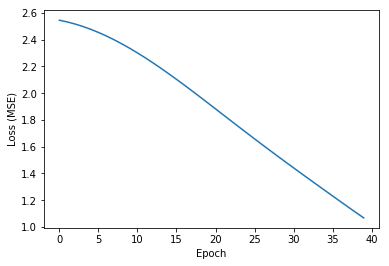

In [9]:
optim = eOptim.StiefelOpt([W], lr=0.0001)
bimap_func = eF.BiMap.apply
spd_arr = []
wne_arr = []
wor_arr = []
loss_arr = []

def check_spd(mat1):
    """
    check for spd by checking for positive norms of submatrices X[0:idx, 0:idx] where 0 < idx <= rank(X)
    Also check for symmetry.
    """
    result = True
    for idx in range(1, mat1.shape[0]):
        norm_val = mat1[:idx, :idx].norm()
        if norm_val <= 0.0:
            result = False
        for midx in range(idx, mat1.shape[0]):
            if (mat1[idx, midx] - mat1[midx, idx]) > 1e-4:
                result = False
    return result

def check_sortho(mat1):
    """
    Check to make sure matrix is semi-orthogonal 
    """
    tmat = mat1 @ mat1.t()
    idxs = torch.ones(3).diag() == 0
    return (tmat[idxs] < 1e-6).all()

# Loop through weight updates and check parameters and outputs
for epoch in range(40):
    W_old = W.clone().detach()
    output = bimap_func(X, W)
    loss = (output - tgt).norm()
    loss_arr.append(loss.item())
    loss.backward()
    optim.step()
    spd_arr.append(check_spd(output))
    wne_arr.append((W == W_old).sum() == 0)
    wor_arr.append(check_sortho(W))

# Ensure Parameters actually updated
assert(torch.tensor(wne_arr).all())
# Ensure updated Parameters are semi-orthogonal
assert(torch.tensor(wor_arr).all())
# Ensure Output is SPD
assert(torch.tensor(spd_arr).all())

# Plot Loss over time
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
print("Output: \n\t{:s}".format(output.__repr__()))
print("Target: \n\t{:s}".format(tgt.__repr__()))
    
    

